[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/accdavlo/calcolo-scientifico/blob/main/codes/solutions/transport_FD.ipynb)

# Heat equation

In this notebook we will solve the 1D Heat parabolic equation given 
$$\partial_t u -\partial_{xx} u = f .$$

Let us start with an example on the domain $\Omega=[0,1]$  and time domain $[0,T]$ with $T=1$ with $f=0$, homogeneous Dirichlet BC $u(0)=u(2\pi)=0$ and initial condition $u_0(x)=\sin(x)$.

In [1]:
try:
    from geometry import *
except ImportError:
    !wget https://raw.githubusercontent.com/accdavlo/calcolo-scientifico/refs/heads/main/codes/solutions/geometry.py -O geometry.py
    from geometry import *

try:
    import nodepy
except ImportError:
    !pip install nodepy
    from geometry import *
    
import numpy as np
import matplotlib.pyplot as plt

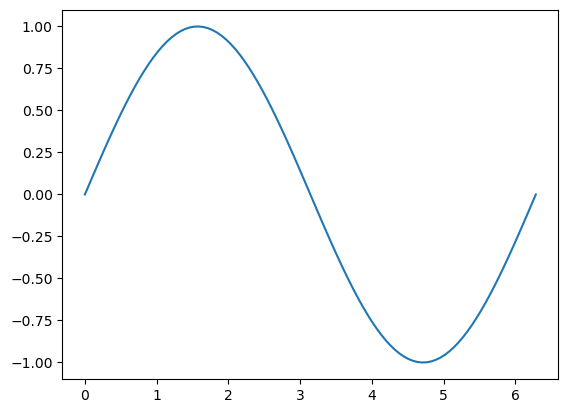

In [2]:
geom = Geometry1D(0,2*np.pi,100)
u0 = np.sin(geom.xx)
T_end = 1.
plt.plot(geom.xx,u0)

### Explicit Euler with central difference implementation
$$
\frac{u^{n+1}_i-u^n_i}{\Delta t} +a \frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}=0 
$$

Final error  605023581.2201186


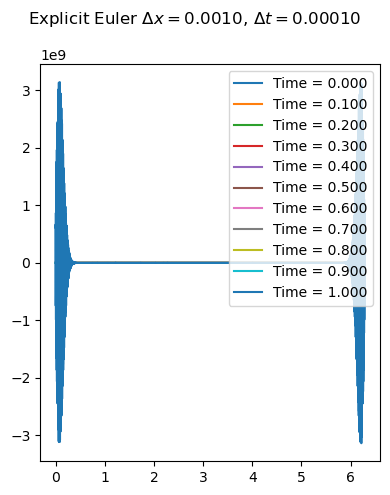

In [3]:
Nx = 6280
geom = Geometry1D(0,2*np.pi,Nx)
dt = 0.0001
u0_lambda = lambda x: np.sin(x)
u_ex = lambda t,x, a: u0_lambda(x-a*t)
T_end = 1.

class Advection_explicit_euler:
    def __init__(self, geom, T_end, u0_lambda, dt, a=1, dt_save = 0.1, u_ex_lambda = None):
        self.geom = geom
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.u0 = self.u0_lambda(self.geom.xx)
        self.set_dt(dt)
        self.a = a
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda



    def set_geom(self,dx=None,Nx=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.u0 = self.u0_lambda(self.geom.xx)
        
    def set_dt(self,dt):
        self.dt = dt
        self.Nt = np.int64(self.T_end//self.dt+2)        
    
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt and time<self.T_end):

            time=time+self.dt
            time_save = time_save+self.dt
            it+=1
            un1[1:-1] = un[1:-1]-self.a*self.dt/self.geom.dx/2.*(un[2:]-un[:-2])
            
            # Periodic BC
            un1[0]  = un[0] -self.a*self.dt/self.geom.dx/2.*(un[1]-un[-2])
            un1[-1] = un1[0]

            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx, self.a)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            # print("Final error ",self.error)
        return self.geom.xx, un1
    
FD_approx = Advection_explicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)
xx, un1 = FD_approx.evolve()
print("Final error ",FD_approx.error)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(FD_approx.times):
    ax1.plot(geom.xx, FD_approx.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, FD_approx.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Explicit Euler $\Delta x=%1.4f, \, \Delta t=%1.5f$"%(geom.dx,FD_approx.dt))
plt.tight_layout()
plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.pdf"%(geom.dx,dt))
plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))
plt.show()


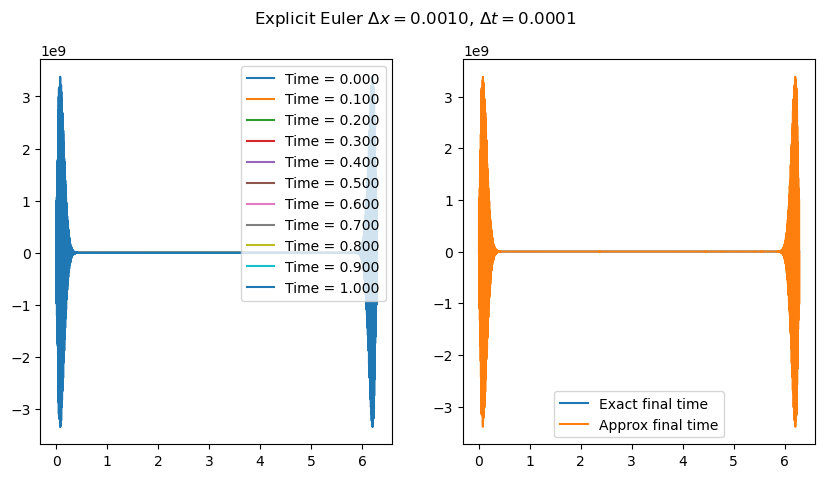

In [4]:
FD_approx.set_geom(dx=0.001)
FD_approx.set_dt(0.0001)
xx, un1 = FD_approx.evolve()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for it, time in enumerate(FD_approx.times):
    ax1.plot(geom.xx, FD_approx.U_sol[it], label="Time = %1.3f"%time)

ax2.plot(geom.xx, FD_approx.u_ex_end, label="Exact final time")
ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
ax2.legend()

fig.suptitle(r"Explicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,FD_approx.dt))
plt.show()

### Implicit Euler

$$
\frac{u^{n}_i-u^{n-1}_i}{\Delta t} +a \frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}=0 
\Longleftrightarrow u^{n}_i-\frac{\Delta t}{2\Delta x}(u_{i+1}^n-u_{i-1}^n) = u^{n-1}_i
$$

### Linear systems with matrix
$$
\begin{pmatrix}
1 &\frac{\Delta t}{2\Delta x} & 0&\dots & \dots\\
-\frac{\Delta t}{2\Delta x} &1 &\frac{\Delta t}{2\Delta x} &\dots & \dots\\
\vdots & \ddots & \ddots & \ddots &\vdots\\
0&\dots & \dots &-\frac{\Delta t}{2\Delta x} &1     
\end{pmatrix}
$$


Final error  0.05337548029350976


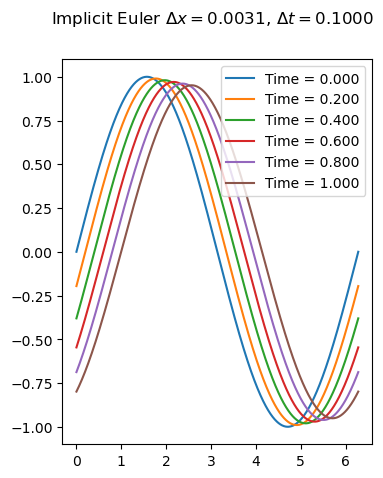

In [5]:
Nx = 2000
dt = 0.1
geom = Geometry1D(0,2*np.pi,Nx)
u0_lambda = lambda x: np.sin(x)
T_end = 1.





def assemble_deriv_matrix(geom):
    deriv_matrix = -0.5*np.diag(np.ones(geom.N-1),-1)\
                    +0.5* np.diag(np.ones(geom.N-1),1)
    # Periodic BC 
    deriv_matrix[0,-2] = -0.5
    deriv_matrix[-1,1] = 0.5
    return deriv_matrix


#def apply_BC_matrix(lhs_matrix):
#    lhs_matrix[0,:] = 0
#    lhs_matrix[0,0] = 1.
#    lhs_matrix[-1,:] = 0
#    lhs_matrix[-1,-1] = 1.


#def apply_BC_vector(rhs, uL = 0., uR = 0.):
#    rhs[0] = uL
#    rhs[-1] = uR



class Advection_implicit_euler:
    def __init__(self, geom, T_end, u0_lambda, dt, a=1.,dt_save = 0.1, u_ex_lambda = None):
        self.geom = geom
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.u0 = self.u0_lambda(self.geom.xx)
        self.a = a
        self.set_dt(dt)
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda
        self.assemble_lhs()

    def assemble_lhs(self):
        self.deriv_matrix = assemble_deriv_matrix(self.geom)
        self.lhs_matrix = np.eye(self.geom.N) + self.a*self.dt/self.geom.dx*self.deriv_matrix
        # Periodic BC already implemented
        
        #apply_BC_matrix(self.lhs_matrix)
    
    def assemble_rhs(self,un, uL=0, uR=0):
        rhs = un
        # Periodic BC already implemented in system
        # apply_BC_vector(rhs, uL, uR)
        return rhs

    def set_geom(self,dx=None,Nx=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.u0 = self.u0_lambda(self.geom.xx)
        self.assemble_lhs() 
        
    def set_dt(self,dt):
        self.dt = dt
        self.Nt = np.int64(self.T_end//self.dt+2)        
        self.assemble_lhs()
        
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt and time<self.T_end):

            time=time+self.dt
            time_save = time_save+self.dt
            it+=1
            
            rhs = self.assemble_rhs(un, uL = np.sin(0.-self.a*time), uR = np.sin(2.*np.pi-self.a*time))
            un1 = np.linalg.solve(self.lhs_matrix, rhs)

            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx, self.a)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            # print("Final error ",self.error)
        return self.geom.xx, un1
    
IE_FD_approx = Advection_implicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)
xx, un1 = IE_FD_approx.evolve()
print("Final error ",IE_FD_approx.error)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(IE_FD_approx.times):
    ax1.plot(geom.xx, IE_FD_approx.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, IE_FD_approx.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Implicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,IE_FD_approx.dt))
plt.savefig("imp_eul_central_diff_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))
plt.show()




Final error  0.39598957609043284


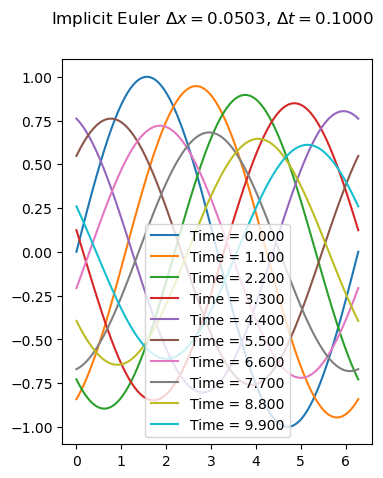

In [6]:

IE_FD_approx = Advection_implicit_euler(geom, 10, u0_lambda, 0.1, dt_save = 1, u_ex_lambda = u_ex)
IE_FD_approx.set_geom(dx = 0.05)
xx, un1 = IE_FD_approx.evolve()
print("Final error ",IE_FD_approx.error)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(IE_FD_approx.times):
    ax1.plot(geom.xx, IE_FD_approx.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, IE_FD_approx.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Implicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,IE_FD_approx.dt))
plt.savefig("imp_eul_central_diff_T_10_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))

plt.show()




In [ ]:
IE_FD_approx.set_geom(dx = 0.01)
IE_FD_approx.set_dt(0.01)
xx, un1 = IE_FD_approx.evolve()
print("Final error ",IE_FD_approx.error)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for it, time in enumerate(IE_FD_approx.times):
    ax1.plot(geom.xx, IE_FD_approx.U_sol[it], label="Time = %1.3f"%time)

ax2.plot(geom.xx, IE_FD_approx.u_ex_end, label="Exact final time")
ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
ax2.legend()

fig.suptitle(r"Implicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,IE_FD_approx.dt))
plt.show()


In [ ]:
IE_FD_approx.set_geom(Nx=20)
IE_FD_approx.set_dt(0.1)
print(np.linalg.eigvals(IE_FD_approx.lhs_matrix))


[1.+3.01361562e-01j 1.-3.01361562e-01j 1.+2.93141204e-01j
 1.-2.93141204e-01j 1.+2.76924718e-01j 1.-2.76924718e-01j
 1.+2.53154448e-01j 1.-2.53154448e-01j 1.+2.22478785e-01j
 1.-2.22478785e-01j 1.+1.85734480e-01j 1.-1.85734480e-01j
 1.+2.96168397e-09j 1.-2.96168397e-09j 1.+4.97724810e-02j
 1.-4.97724810e-02j 1.+9.81872985e-02j 1.-9.81872985e-02j
 1.+1.43923822e-01j 1.-1.43923822e-01j]


## Other spatial discretizations!

In [ ]:
# Define some spatial discretizations for linear advection as a function of
# um1 $u_{i-1}$, u $u_i$ and up1 $u_{i+1}$
# a speed, dt timestep, dx spacestep
def Lax_Friedrichs(um2,um1,u,up1,up2,a, dt,dx):
    advection = (up1-2*u+um1)/2. - a*dt/dx*(up1-um1)/2
    return advection

def central(um2,um1,u,up1,up2, a,dt,dx):
    advection = - a*dt/dx*(up1-um1)/2
    return advection

def Lax_Wendroff(um2,um1,u,up1,up2, a,dt,dx):
    advection = - a*dt/dx*(up1-um1)/2 +(a*dt/dx)**2*(um1-2*u+up1)/2
    return advection

def Beam_Warming(um2,um1,u,up1,up2, a,dt,dx):
    advection = (a>0)*(- a*dt/dx/2*(um2-4*um1+3*u) +a**2*dt**2/dx**2*(um2-2*um1+u)/2)+\
                (a<0)*(- a*dt/dx/2*(-3*u+4*up1-up2) +a**2*dt**2/dx**2*(u-2*up1+up2)/2)
    return advection

def upwind(um2,um1,u,up1,up2, a,dt,dx):
    advection = - a*dt/dx*(u-um1)*(a>0)- a*dt/dx*(up1-u)*(a<0)
    return advection



class SpatialDiscretizationAdvection:
    def __init__(self,method, boundary):
        self.boundary = boundary
        self.method = method
        if self.method == "Lax_Friedrichs":
            self.advection = Lax_Friedrichs
        elif self.method =="central":
            self.advection = central
        elif self.method =="Lax_Wendroff":
            self.advection = Lax_Wendroff
        elif self.method =="upwind":
            self.advection = upwind
        elif self.method =="Beam_Warming":
            self.advection = Beam_Warming
            
    def eval(self,u,a,dt,dx):
        if self.boundary=="periodic":
            u_red = u[:-1]
            # u_{i+1} using periodic BC
            up1 = np.roll(u_red,-1)
            # u_{i+2} using periodic BC
            up2 = np.roll(up1,-1)
            # u_{i-1} using periodic BC
            um1 = np.roll(u_red,1)
            # u_{i-2} using periodic BC
            um2 = np.roll(um1,1)
            adv_red = self.advection(um2,um1,u_red,up1,up2,a,dt,dx)
            adv = np.concatenate([adv_red, [adv_red[0]]])
        return adv


In [ ]:

class Advection_explicit_euler:
    def __init__(self, geom, T_end, u0_lambda, dt,\
                 spatial_discretization_type = "Lax_Friedrics",
                 a=1, dt_save = 0.1, u_ex_lambda = None):
        self.geom = geom
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.u0 = self.u0_lambda(self.geom.xx)
        self.set_dt(dt)
        self.a = a
        self.spatial_discretization_type = spatial_discretization_type
        self.space_discr = SpatialDiscretizationAdvection(\
            self.spatial_discretization_type, boundary="periodic")
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda



    def set_geom(self,dx=None,Nx=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.u0 = self.u0_lambda(self.geom.xx)
        
    def set_dt(self,dt):
        self.dt = dt
        self.Nt = np.int64(self.T_end//self.dt+2)        
    
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt and time<self.T_end):

            time=time+self.dt
            time_save = time_save+self.dt
            it+=1
            un1 = un +self.space_discr.eval(un,self.a,self.dt,self.geom.dx)
            
            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx, self.a)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            # print("Final error ",self.error)
        return self.geom.xx, un1


In [ ]:
geom = Geometry1D(0,1.,100)
dt = geom.dx*0.9
T_end = 1
u0_lambda = lambda x: np.sin(2*np.pi*x)
u_ex_lambda = lambda t,x,a : u0_lambda(x-a*t)
spatial_discretization_type = "Beam_Warming"#"upwind"#"central"#"Lax_Wendroff"#"Lax_Friedrichs"

EE_advection = Advection_explicit_euler( geom, T_end, u0_lambda, dt, \
                     spatial_discretization_type=spatial_discretization_type,
                 a=1, dt_save = 0.1, u_ex_lambda =u_ex_lambda)
print("Final error ",EE_advection.error)


Final error  0.00047278630789345064


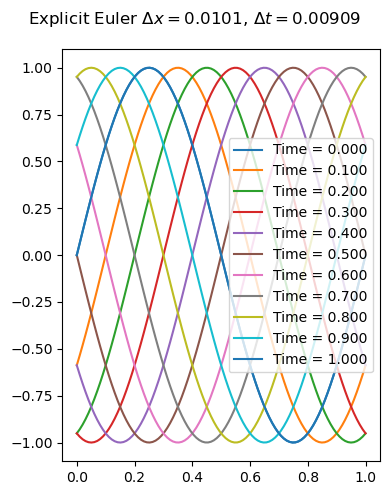

In [ ]:

xx, un1 = EE_advection.evolve()
print("Final error ",EE_advection.error)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(EE_advection.times):
    ax1.plot(geom.xx, EE_advection.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, EE_advection.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Explicit Euler $\Delta x=%1.4f, \, \Delta t=%1.5f$"%(geom.dx,EE_advection.dt))
plt.tight_layout()
#plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.pdf"%(geom.dx,dt))
#plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))
plt.show()


## Plotting von Neumann coefficients

In [ ]:
from nodepy import rk


# Explicit Euler as a RK
A = np.array([[0]])
b = np.array([1])

# # Implicit Euler as a RK
# A = np.array([[1]])
# b = np.array([1])

# # Crank Nicolson
# A = np.array([[0,0],[0.5,0.5]])
# b = np.array([0.5,0.5])

myrk = rk.RungeKuttaMethod(A,b)
myrk.name = "Explicit Euler"

                       being initialized as a RungeKuttaMethod rather than
                       as an ExplicitRungeKuttaMethod.


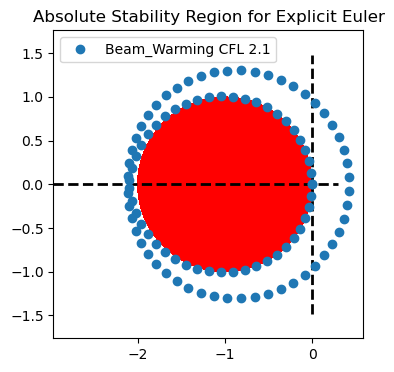

In [ ]:
# Von neumann coefficients
CFL = 2.1
spatial_discretization_type ="Beam_Warming"#"upwind"

EE_advection = Advection_explicit_euler( geom, T_end, u0_lambda, dt, \
                     spatial_discretization_type=spatial_discretization_type,
                 a=1, dt_save = 0.1, u_ex_lambda =u_ex_lambda)
a = EE_advection.a
dx = EE_advection.geom.dx
dt = CFL*dx/np.abs(a)

thetas = np.linspace(0,2*np.pi,100)
u  = 1.
um1 = np.exp(-1j*thetas)
um2 = np.exp(-2j*thetas)
up1 = np.exp(1j*thetas)
up2 = np.exp(2j*thetas)

advection = EE_advection.space_discr.advection(um2,um1,u,up1,up2,a,dt,dx)

myrk.plot_stability_region()
fig = plt.gcf()
fig.set_size_inches(4,4)

plt.plot(np.real(advection),np.imag(advection),'o', label=spatial_discretization_type+" CFL %1.1f"%CFL)
plt.axis("equal")
plt.legend();
plt.savefig("von_neumann_stab_advection_"+spatial_discretization_type+"_CFL_%1.1f.png"%CFL)


## Comparison of different methods

Method =  Beam_Warming
Final error  0.18093113813073886
Method =  upwind
Final error  0.24395567896400275
Method =  Lax_Wendroff
Final error  0.183250309056352
Method =  Lax_Friedrichs
Final error  0.3210994626609815


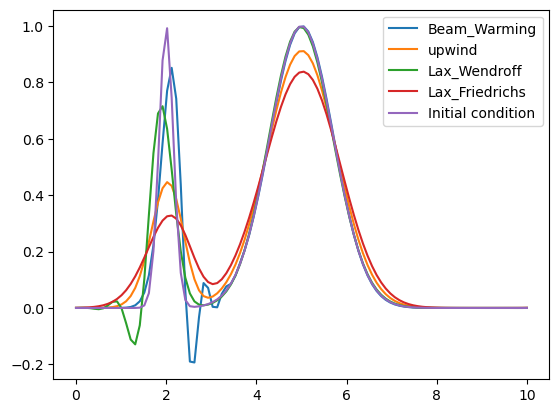

In [ ]:
u0_lambda = lambda x : np.exp(-20*(x-2)**2)+np.exp(-(x-5)**2)
x_L=0.
x_R=10.
Nx = 100
T_end = 10.
geom = Geometry1D(x_L,x_R,Nx)

CFL = 0.9
a = 1.
dx = geom.dx
dt = CFL*dx/np.abs(a)


u_ex_lambda = lambda t,x,a : u0_lambda((x-a*t)%10)

spatial_discretizations  = ["Beam_Warming","upwind","Lax_Wendroff","Lax_Friedrichs"] #,"central"

for spatial_discretization_type in spatial_discretizations:
    print("Method = ",spatial_discretization_type)
    EE_advection = Advection_explicit_euler( geom, T_end, u0_lambda, dt, \
                     spatial_discretization_type=spatial_discretization_type,
                 a=a, dt_save = 0.1, u_ex_lambda =u_ex_lambda)
    xx, un1 = EE_advection.evolve()
    print("Final error ",EE_advection.error)
    plt.plot(xx,un1, label=spatial_discretization_type)

plt.plot(geom.xx, u0(geom.xx), label="Initial condition")

plt.legend()

## Check order of accuracy
If $\Delta x \to 0$ then $e^{\Delta x}=\lVert u^{\Delta x} - u^{ex} \rVert \to 0$. How does it go to zero?

Final error  0.3741574285903043
Final error  0.6255411050378387
Final error  0.3668826312356544
Final error  0.2721055179805363
Final error  0.13222095781455478
Final error  0.040361813855629786
Final error  0.01035072389468588
Final error  0.0025931600306473737
Final error  0.0006480851762116391
Final error  0.47253397913326844
Final error  0.46594366187325265
Final error  0.35875287449864046
Final error  0.28956058205499424
Final error  0.220305695714011
Final error  0.1554190739445393
Final error  0.10001166855860923
Final error  0.05898833947971477
Final error  0.032521323500787756
Final error  0.47423594702100946
Final error  0.37220140494891296
Final error  0.30739499853491953
Final error  0.23928445195188172
Final error  0.1493638834613102
Final error  0.06122504774076329
Final error  0.017515024462183972
Final error  0.0044671676382409395
Final error  0.0011190260044244141
Final error  0.6860644103481253
Final error  0.6232813087254847
Final error  0.4983071846315191
Final erro

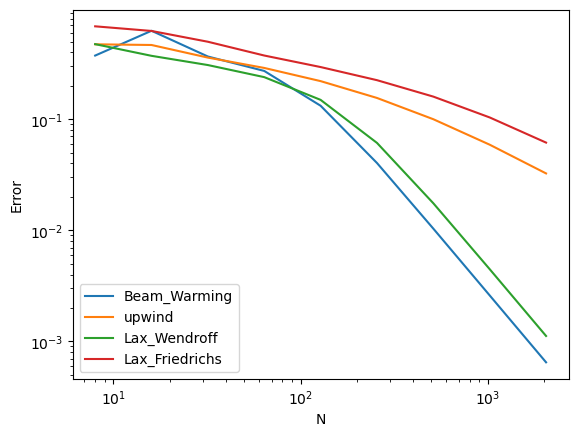

In [ ]:
Ns = np.int64(2**np.arange(6,12))

u0_lambda = lambda x : np.exp(-20*(x-2)**2)+np.exp(-(x-5)**2)
x_L=0.
x_R=10.
geom = Geometry1D(x_L,x_R,10)


T_end = 10.

CFL = 0.9
a = 1.

u_ex_lambda = lambda t,x,a : u0_lambda((x-a*t)%10)

spatial_discretizations  = ["Beam_Warming","upwind","Lax_Wendroff","Lax_Friedrichs"] #,"central"
errors = np.zeros((len(spatial_discretizations),len(Ns)))

for itype, spatial_discretization_type in enumerate(spatial_discretizations):
    advection_solver = Advection_explicit_euler( geom, T_end, u0_lambda, dt, \
                     spatial_discretization_type=spatial_discretization_type,
                 a=a, dt_save = 0.1, u_ex_lambda =u_ex_lambda)


    for iN, N in enumerate(Ns):
        advection_solver.set_geom(Nx=N)
        advection_solver.set_dt(CFL*advection_solver.geom.dx/np.abs(advection_solver.a))
        xx, un1 = advection_solver.evolve()

        errors[itype,iN] = advection_solver.error


plt.figure()
plt.loglog(Ns, errors.T, label=spatial_discretizations)
# plt.loglog(Ns,1./np.array(Ns), ":",label="First order")
# plt.loglog(Ns,1./np.array(Ns)**2, ":", label="Second order")
# plt.loglog(Ns,1./np.array(Ns)**3, ":", label="Third order")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()

Final error  0.4482222458375856
Final error  0.20805272276245462
Final error  0.06383831649171152
Final error  0.03173598586638731
Final error  0.015827801141234058


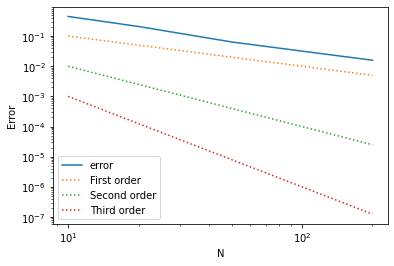

In [ ]:
# Implicit Euler
Ns = [10,20,50,100,200]

u0_lambda = lambda x: np.sin(x)
T_end = 1.
geom = Geometry1D(0,2*np.pi,5)

FD_approx = Heat_implicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)

# Implicit Euler
errors = np.zeros(len(Ns))
for iN, N in enumerate(Ns):
    FD_approx.set_geom(Nx=N)
    FD_approx.set_dt(FD_approx.geom.dx)
    _, _ = FD_approx.evolve()
    
    
    errors[iN] = FD_approx.error
    
plt.figure()
plt.loglog(Ns, errors, label="error")
plt.loglog(Ns,1./np.array(Ns), ":",label="First order")
plt.loglog(Ns,1./np.array(Ns)**2, ":", label="Second order")
plt.loglog(Ns,1./np.array(Ns)**3, ":", label="Third order")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()

Final error  0.8846246239604766
Final error  0.5239431962245451
Final error  0.06730117126126732
Final error  0.016353103628053096
Final error  0.004028493234851537
Final error  0.0009996537718130346


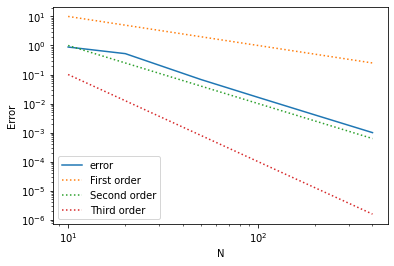

In [ ]:
# Crank-Nicolson
Ns = [10,20,50,100,200,400]

u0_lambda = lambda x: np.sin(2.*x)
u_ex = lambda t,x: np.exp(-4*t)*np.sin(2*x)
T_end = 1.
geom = Geometry1D(0,2*np.pi,5)

FD_approx = Heat_CN(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)

# Implicit Euler
errors = np.zeros(len(Ns))
for iN, N in enumerate(Ns):
    FD_approx.set_geom(Nx=N)
    FD_approx.set_dt(FD_approx.geom.dx)
    _, _ = FD_approx.evolve()
    
    
    errors[iN] = FD_approx.error
    
plt.figure()
plt.loglog(Ns, errors, label="error")
plt.loglog(Ns,100./np.array(Ns), ":",label="First order")
plt.loglog(Ns,100./np.array(Ns)**2, ":", label="Second order")
plt.loglog(Ns,100./np.array(Ns)**3, ":", label="Third order")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()

## Exercises
1. Different boundary conditions: periodic, Neumann, etc.
1. Different initial conditions (low and fast frequencies together, e.g. sin(x) + cos(10 x)

## Von Neumann Stability

In [ ]:
# complex united is denoted by 1j in python, so the number 3+i is 
3+1j

(3+1j)

In [ ]:
from nodepy import rk

In [ ]:
np.imag(second_derivative_fourier(np.linspace(0,6,10)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

                       being initialized as a RungeKuttaMethod rather than
                       as an ExplicitRungeKuttaMethod.


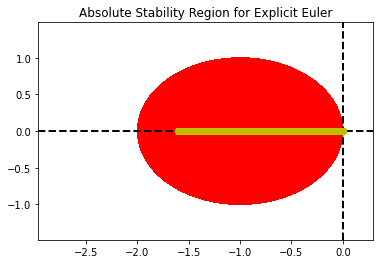

In [ ]:
# Fourier analogous of second derivative operator as a function of $k*\Delta x$
second_derivative_fourier = lambda kdx: np.exp(-1j*kdx) -2+ np.exp(1j*kdx)
dt = 0.001
dx = 0.05

# Explicit Euler as a RK
A = np.array([[0]])
b = np.array([1])

# # Implicit Euler as a RK
# A = np.array([[1]])
# b = np.array([1])

# # Crank Nicolson
# A = np.array([[0,0],[0.5,0.5]])
# b = np.array([0.5,0.5])

myrk = rk.RungeKuttaMethod(A,b)
myrk.name = "Explicit Euler"
myrk.plot_stability_region()


kdxs = np.linspace(0,2*np.pi, 1000)
eigvalues = dt/dx**2*second_derivative_fourier(kdxs)

plt.plot(np.real(eigvalues), np.imag(eigvalues),'yo')


## Exercise
1. Check that for stable values of von Neumann we have stable simulations
1. Sparse implementation of matrices and decomposition of matrices to save computational time (check [Scipy sparse incomplete LU](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spilu.html)
1. Finite element implementation (either 1D or 2D with FEniCS)